In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

In [189]:
df= pd.read_csv('../data/train.csv')

In [190]:
#drop redundant columns
df.drop(columns=['hasDamage','previousOwners', 'paintQuality%'], inplace=True)
# change column name
df.rename(columns={'carID': 'car_id','Brand': 'brand', 'fuelType': 'fuel_type', 'engineSize': 'engine_size'}, inplace=True)

In [ ]:
# turn negative mileage values to positive
df['mileage'] = df['mileage'].abs()
df['tax'] = df['tax'].abs()
df['engine_size'] = df['engine_size'].abs()
# remove entries where year <= 1970 
df = df[df['year'] > 1970]

In [192]:
df.head()

,car_id,brand,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5


In [193]:
# show null values percentages in a dataframe
df.isnull().sum() / len(df) * 100

car_id           0.000000
brand            1.996509
model            1.992481
year             0.000000
price            0.000000
transmission     2.007250
mileage          1.934748
fuel_type        1.985768
tax             10.392052
mpg             10.422932
engine_size      2.003222
dtype: float64

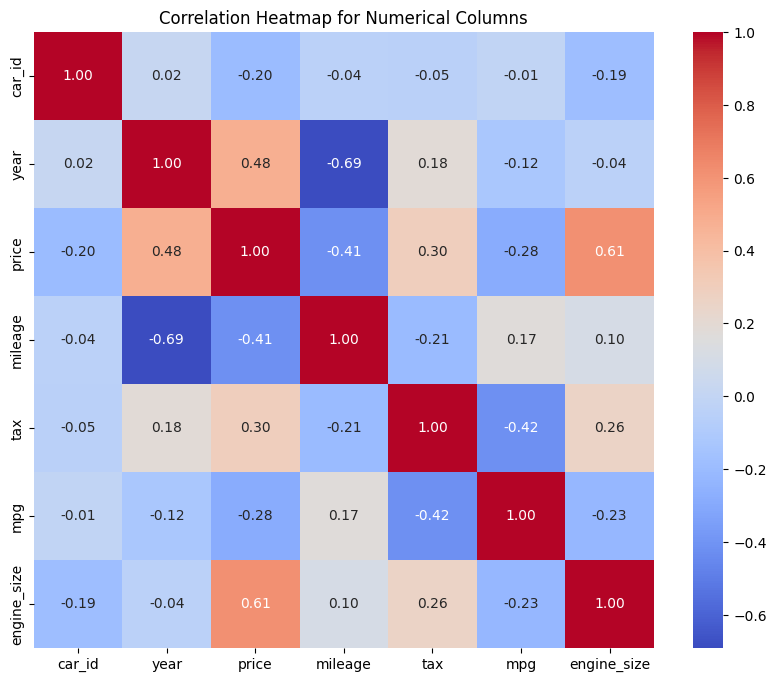

In [194]:
# plot correlation heatmap for numerical columns
num_cols= df.select_dtypes(include=['number']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Numerical Columns")
plt.show()

In [195]:
df['mileage'] = df['mileage'].clip(lower=0, upper=175000)

**input brand**

In [196]:
# 1. Compute the most frequent brand for each model
most_freq_brand_per_model = (
    df.dropna(subset=['brand', 'model'])
      .groupby('model')['brand']
      .agg(lambda x: x.value_counts().idxmax())
)

# 2. Fill missing brand values based on model
df['brand'] = df.apply(
    lambda x: most_freq_brand_per_model[x['model']]
    if pd.isna(x['brand']) and x['model'] in most_freq_brand_per_model.index
    else x['brand'],
    axis=1
)

**input model**

In [197]:


# Copy the DataFrame
df_model_impute = df.copy()

# --- 1. Encode categorical features ---
cat_cols = ['fuel_type', 'transmission']
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    df_model_impute[col] = df_model_impute[col].astype(str)
    df_model_impute[col] = enc.fit_transform(df_model_impute[col])
    encoders[col] = enc

# --- 2. Encode model (target to impute) ---
model_encoder = LabelEncoder()
known_models = df_model_impute['model'].dropna().unique()
model_encoder.fit(known_models)

df_model_impute['model_enc'] = np.nan
mask_known = df_model_impute['model'].notna()
df_model_impute.loc[mask_known, 'model_enc'] = df_model_impute.loc[mask_known, 'model'].map(
    dict(zip(model_encoder.classes_, model_encoder.transform(model_encoder.classes_)))
)

# --- 3. Define KNN imputation function within each brand ---
def knn_impute_models(group):
    if group['model_enc'].isna().all():
        return group  # nothing to do

    features = ['year', 'engine_size', 'fuel_type', 'transmission', 'model_enc']

    # Scale numeric data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(group[features])

    # Impute
    imputer = KNNImputer(n_neighbors=3)
    imputed_scaled = imputer.fit_transform(scaled)

    # Descales back
    imputed = scaler.inverse_transform(imputed_scaled)

    # Assign back the model_enc (last column)
    group['model_enc'] = imputed[:, -1]
    return group

# --- 4. Apply by brand ---
df_model_impute = df_model_impute.groupby('brand', group_keys=False).apply(knn_impute_models)

# --- 5. Decode models back to string labels ---
df_model_impute['model_imputed'] = df_model_impute['model_enc'].round().astype(int)
df_model_impute['model_imputed'] = np.clip(df_model_impute['model_imputed'], 0, len(model_encoder.classes_) - 1)
df_model_impute['model_imputed'] = model_encoder.inverse_transform(df_model_impute['model_imputed'])

# --- 6. Fill missing models ---
df['model'] = df['model'].fillna(df_model_impute['model_imputed'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3720\1672586843.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_model_impute = df_model_impute.groupby('brand', group_keys=False).apply(knn_impute_models)


**input when brand and model are missing**

In [198]:
df_brand_model = df.copy()

# --- 1. Encode categorical predictors ---
cat_cols = ['fuel_type', 'transmission']
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    df_brand_model[col] = df_brand_model[col].astype(str)
    df_brand_model[col] = enc.fit_transform(df_brand_model[col])
    encoders[col] = enc

# --- 2. Encode target columns (brand + model) numerically ---
brand_encoder = LabelEncoder()
model_encoder = LabelEncoder()

known_brands = df_brand_model['brand'].dropna().unique()
known_models = df_brand_model['model'].dropna().unique()

brand_encoder.fit(known_brands)
model_encoder.fit(known_models)

df_brand_model['brand_enc'] = np.nan
df_brand_model['model_enc'] = np.nan

mask_brand_known = df_brand_model['brand'].notna()
mask_model_known = df_brand_model['model'].notna()

df_brand_model.loc[mask_brand_known, 'brand_enc'] = df_brand_model.loc[mask_brand_known, 'brand'].map(
    dict(zip(brand_encoder.classes_, brand_encoder.transform(brand_encoder.classes_)))
)
df_brand_model.loc[mask_model_known, 'model_enc'] = df_brand_model.loc[mask_model_known, 'model'].map(
    dict(zip(model_encoder.classes_, model_encoder.transform(model_encoder.classes_)))
)

# --- 3. Prepare features for KNN ---
features = ['year', 'tax', 'mpg', 'engine_size', 'fuel_type', 'transmission', 'brand_enc', 'model_enc']

scaler = StandardScaler()
scaled = scaler.fit_transform(df_brand_model[features])

# --- 4. KNN Impute ---
imputer = KNNImputer(n_neighbors=5)
imputed_scaled = imputer.fit_transform(scaled)

# --- 5. Descales ---
imputed = scaler.inverse_transform(imputed_scaled)

# --- 6. Replace brand/model ---
df_brand_model['brand_enc'] = imputed[:, -2]
df_brand_model['model_enc'] = imputed[:, -1]

# Round and clip to valid label indices
df_brand_model['brand_enc'] = np.clip(np.round(df_brand_model['brand_enc']).astype(int), 0, len(brand_encoder.classes_) - 1)
df_brand_model['model_enc'] = np.clip(np.round(df_brand_model['model_enc']).astype(int), 0, len(model_encoder.classes_) - 1)

# Decode back to original names
df_brand_model['brand_imputed'] = brand_encoder.inverse_transform(df_brand_model['brand_enc'])
df_brand_model['model_imputed'] = model_encoder.inverse_transform(df_brand_model['model_enc'])

# --- 7. Fill in missing values ---
df['brand'] = df['brand'].fillna(df_brand_model['brand_imputed'])
df['model'] = df['model'].fillna(df_brand_model['model_imputed'])

**input year**

In [199]:
bins = [0, 10000, 30000, 60000, 100000, 200000, np.inf]
labels = ["0–10k", "10–30k", "30–60k", "60–100k", "100–200k", "200k+"]

df['mileage_range'] = pd.cut(df['mileage'], bins=bins, labels=labels)

avg_years = df.groupby('mileage_range')['year'].mean().to_dict()
df['avg_year_by_mileage'] = df['mileage_range'].map(avg_years)
df['year'] = df['year'].fillna(df['avg_year_by_mileage'])

# round the year values to the nearest integer
df['year'] = np.round(df['year'])

# drop the avg_year_by_mileage column
df = df.drop(columns=['avg_year_by_mileage', 'mileage_range'])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3720\635666962.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_years = df.groupby('mileage_range')['year'].mean().to_dict()


**input mileage**

In [200]:
# 1. Calculate median mileage for each year
median_mileage_by_year = df.groupby('year')['mileage'].median()

# 2. Map those medians back to each row
df['median_mileage_for_year'] = df['year'].map(median_mileage_by_year)

# 3. Fill NaN mileage values with the corresponding median
df['mileage'] = df['mileage'].fillna(df['median_mileage_for_year'])

# 4. Optional: drop the helper column
df.drop(columns=['median_mileage_for_year'], inplace=True)

**input tax**

In [201]:
bins = [0, 50, 110, 175, 200, 240, np.inf]
labels = ['0-50', '50-110', '110-175', '175-200', '200-240', '240+']

# Create bins
df['mpg_bin'] = pd.cut(df['mpg'], bins=bins, labels=labels, include_lowest=True)

# Median tax per bin
median_tax_by_bin = df.groupby('mpg_bin')['tax'].median()

# Safe fill
def fill_tax(row):
    if pd.isna(row['tax']):
        bin_label = row['mpg_bin']
        if pd.notna(bin_label) and bin_label in median_tax_by_bin.index:
            return median_tax_by_bin[bin_label]
        else:
            return df['tax'].median()  # fallback to global median
    return row['tax']

df['tax'] = df.apply(fill_tax, axis=1)

# Cleanup
df.drop(columns='mpg_bin', inplace=True)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3720\2187539166.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_tax_by_bin = df.groupby('mpg_bin')['tax'].median()


**input mpg**

In [202]:
# Define tax bins — tune these based on your data’s range
tax_bins = [0, 50, 150, 300, 600, np.inf]
tax_labels = ['0-50', '50-150', '150-300', '300-600', '600+']

# Create bins
df['tax_bin'] = pd.cut(df['tax'], bins=tax_bins, labels=tax_labels, include_lowest=True)

# Median mpg per tax bin
median_mpg_by_bin = df.groupby('tax_bin')['mpg'].median()

# Fill missing mpg using median of corresponding tax bin
def fill_mpg(row):
    if pd.isna(row['mpg']):
        bin_label = row['tax_bin']
        if pd.notna(bin_label) and bin_label in median_mpg_by_bin.index:
            return median_mpg_by_bin[bin_label]
        else:
            return df['mpg'].median()  # fallback to global median
    return row['mpg']

df['mpg'] = df.apply(fill_mpg, axis=1)

# Cleanup
df.drop(columns='tax_bin', inplace=True)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3720\748727874.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_mpg_by_bin = df.groupby('tax_bin')['mpg'].median()


**input transmission**

In [203]:
from collections import Counter

# Function to find the best matching transmission for each row with missing transmission
def impute_transmission(row, df):
    if pd.notna(row['transmission']):
        return row['transmission']

    search_orders = [
        ['brand', 'model', 'year', 'engine_size', 'fuel_type'],
        ['brand', 'model', 'year', 'engine_size'],
        ['brand', 'model', 'year'],
        ['brand', 'model'],
        ['brand']
    ]

    for cols in search_orders:
        # Filter potential matches
        mask = np.ones(len(df), dtype=bool)
        for c in cols:
            mask &= (df[c] == row[c])

        subset = df.loc[mask & df['transmission'].notna(), 'transmission']

        if not subset.empty:
            # Count occurrences
            counts = Counter(subset)
            if len(counts) == 1:
                return subset.iloc[0]
            else:
                return counts.most_common(1)[0][0]

    return np.nan  # nothing found

# Apply the function
df['transmission'] = df.apply(lambda x: impute_transmission(x, df), axis=1)


**input fuel_type**

In [204]:
def impute_fuel_type(row, df):
    # Skip if already has a fuel_type
    if pd.notna(row['fuel_type']):
        return row['fuel_type']
    
    search_orders = [
        ['brand', 'model', 'year', 'engine_size', 'transmission'],
        ['brand', 'model', 'year', 'engine_size'],
        ['brand', 'model', 'year'],
        ['brand', 'model'],
        ['brand']
    ]
    
    for cols in search_orders:
        mask = np.ones(len(df), dtype=bool)
        for c in cols:
            mask &= (df[c] == row[c])
        
        subset = df.loc[mask & df['fuel_type'].notna(), 'fuel_type']
        
        if not subset.empty:
            counts = Counter(subset)
            # If all same, just use that value
            if len(counts) == 1:
                return subset.iloc[0]
            # Otherwise, most frequent
            return counts.most_common(1)[0][0]
    
    return np.nan

# Apply to DataFrame
df['fuel_type'] = df.apply(lambda x: impute_fuel_type(x, df), axis=1)

**input engine size**

In [205]:
def impute_engine_size(row, df):
    # Skip if already has a value
    if pd.notna(row['engine_size']):
        return row['engine_size']
    
    search_orders = [
        ['brand', 'model', 'year', 'fuel_type', 'transmission'],
        ['brand', 'model', 'year', 'fuel_type'],
        ['brand', 'model', 'year'],
        ['brand', 'model'],
        ['brand']
    ]
    
    for cols in search_orders:
        mask = np.ones(len(df), dtype=bool)
        for c in cols:
            mask &= (df[c] == row[c])
        
        subset = df.loc[mask & df['engine_size'].notna(), 'engine_size']
        
        if not subset.empty:
            return subset.median()  # use median to avoid outlier bias
    
    return np.nan

# Apply it
df['engine_size'] = df.apply(lambda x: impute_engine_size(x, df), axis=1)